## XenonPy-ISMD (Inversed Synthesizable Molecular Design) Totorial

This tutorial provides an introduction to ISMD, an inverse molecular design algorithm based on machine learning. By which we show a complete building process of doing your own inverse molecular design algorithm by XenonPy.

Overview - ISMD aims at finding reactant sets R, such that the properties Y of their synthetic product have a high probability of falling into a target region U, i.e., we want to sample from the posterior probability 𝑝(R|𝑌∈𝑈) that is proportional to 𝑝(𝑌∈𝑈|R)𝑝(R) by the Bayes' theorem. 𝑝(R|𝑌∈𝑈) is the likelihood function, 𝑝(R) is the prior that represents all possible candidates of R. ISMD is a numerical implementation for this Bayesian formulation based on sequential Monte Carlo sampling (SMC), all the building blocks to implement the SMC is supplied by XenonPy, the following of this tutorial will show how to customize each building block to solve the specific task in ISMD.

In [1]:
import warnings
warnings.filterwarnings('ignore')

### download data and model
download the data and model which will be used in this tutorial to your local folder: 
https://drive.google.com/drive/folders/1-uHnS4EcV9dQdSEIlt1n8skCrsZJP-3r?usp=sharing
the ismd_assets folder should contain the following files:
- pool_sim_sparse.npz
- STEREO_id_reactant_product_xlogp_tpsa.csv
- STEREO_pool_df.csv
- STEREO_separated_augm_model_average_20.pt
- figure.png

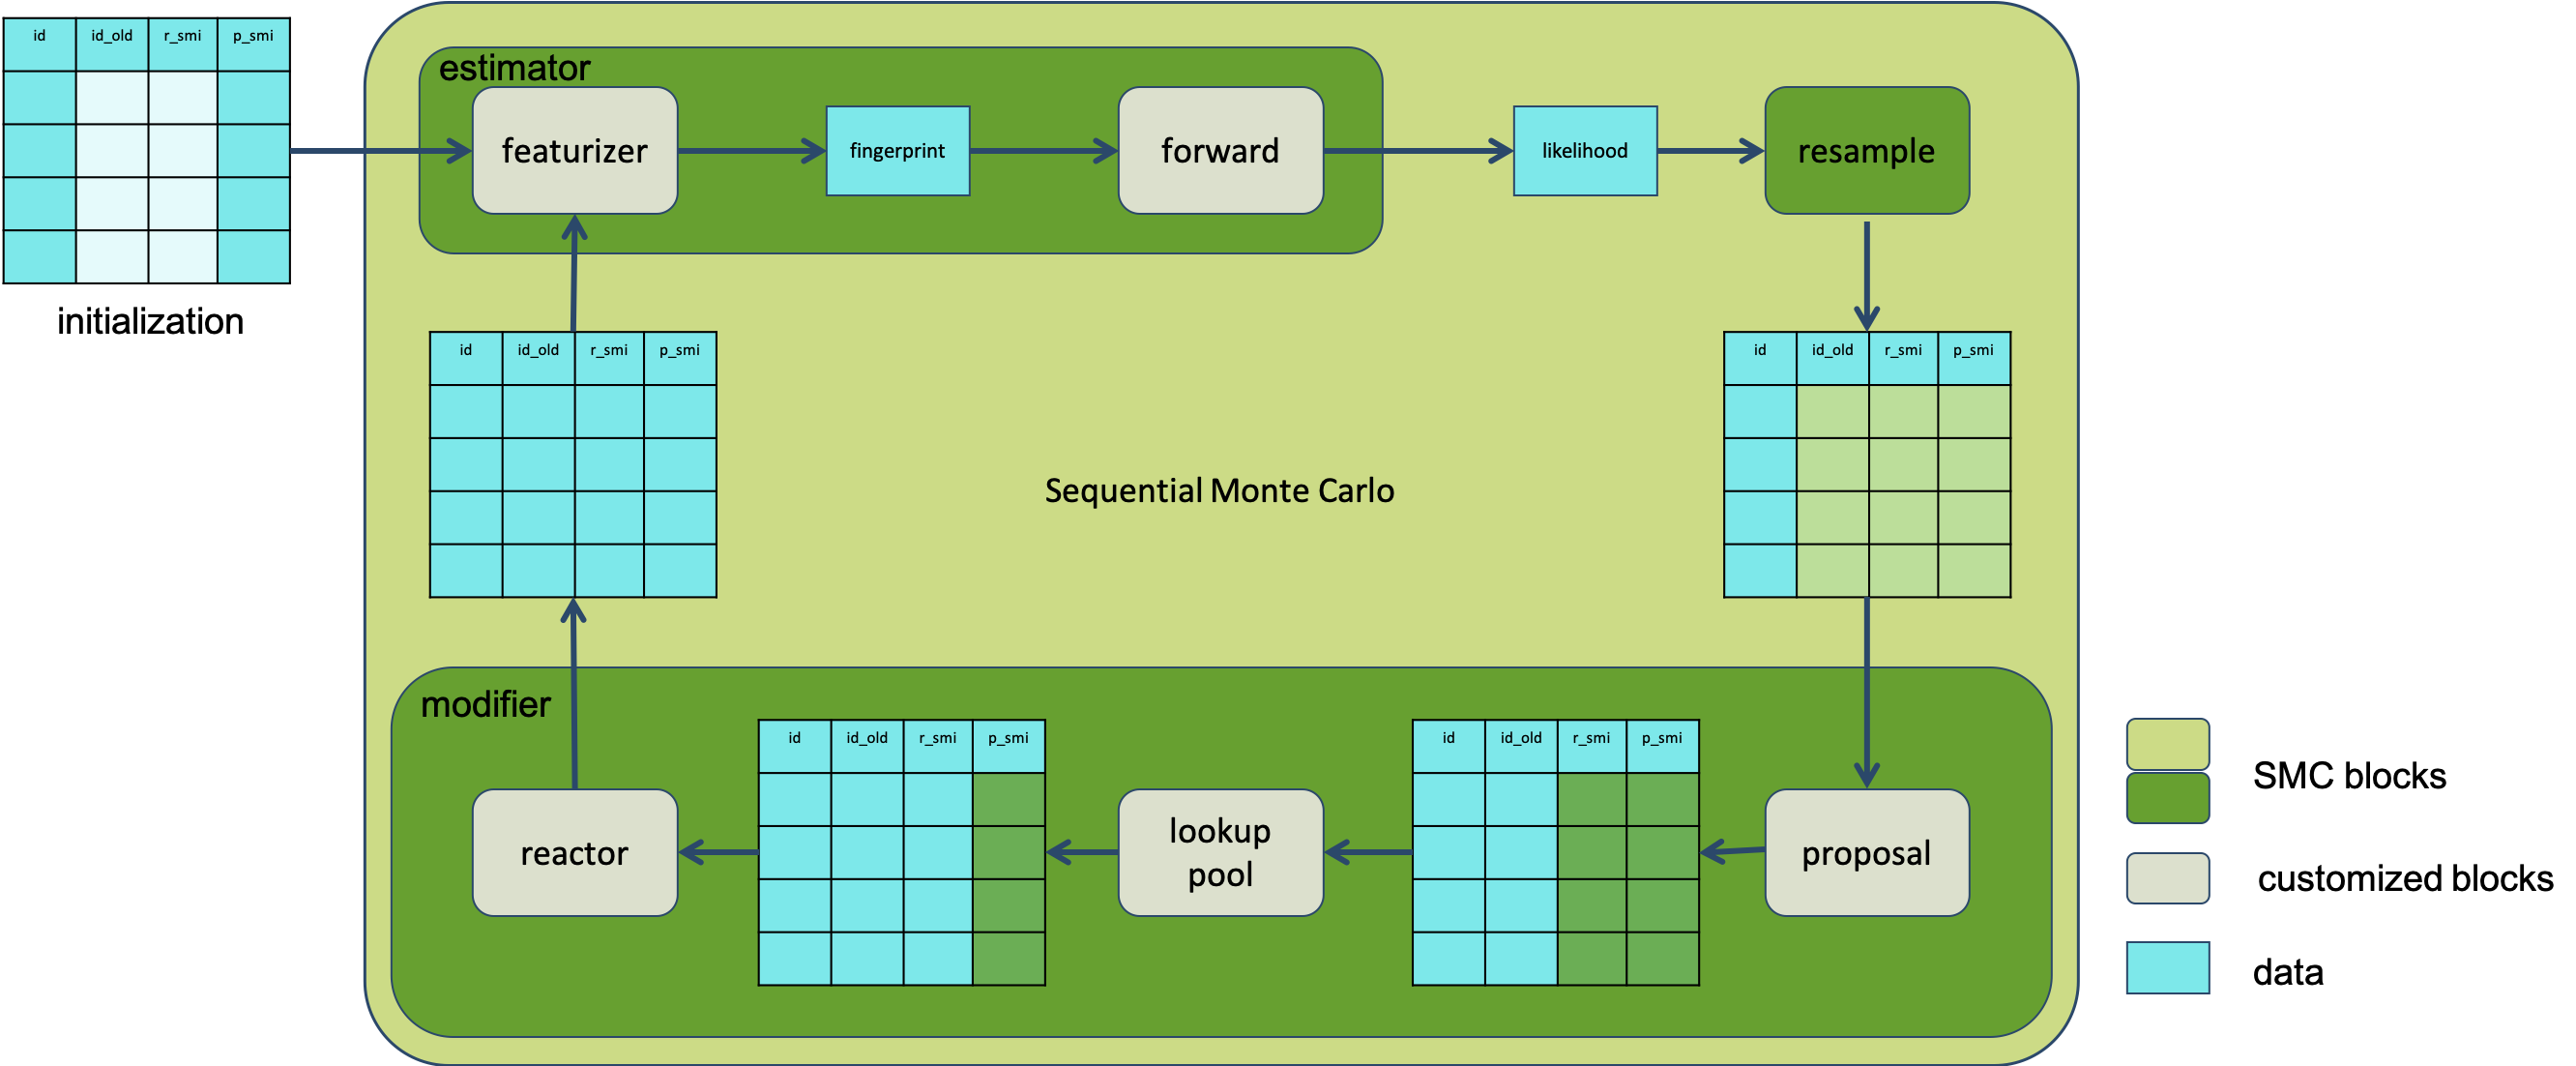

In [2]:
import os
# set path to the downloaded folder
assets_path = "/home/qiz/data/ismd_assets"
from IPython.display import Image
Image(filename=os.path.join(assets_path, 'figure.png'), width=1000, height=600)

An illustruction of ISMD algorithm is shown above.
We will show each items in this figure and how to combine them step by step.

This tutorial will proceed as follow:

1. data introduction
  - ground truth
  - reactant pool
  - similarity matrix
  - initial data
2. estimator
  - featurizer
  - forward model
2. modifier
  - proposal
  - lookup pool
  - reactor
3. a complete ismd run

### 1. data introduction
#### ground truth
ground truth is a pandas dataframe, each row is a chemical reaction record include reactant, product, some physical properties of the product('ECFP', 'MACCS') and the index of each reactant associated with the reactant pool.

In [3]:
import pandas as pd

ground_truth_path = os.path.join(assets_path,"STEREO_id_reactant_product_xlogp_tpsa.csv")
data = pd.read_csv(ground_truth_path)
data.head()

,reactant_index,reactant,product,XLogP,TPSA
0,12163.22445,CCS(=O)(=O)Cl.OCCBr,CCS(=O)(=O)OCCBr,0.8,51.8
1,863.20896,CC(C)CS(=O)(=O)Cl.OCCCl,CC(C)CS(=O)(=O)OCCCl,1.6,51.8
2,249087,O=[N+]([O-])c1cccc2cnc(Cl)cc12,Nc1cccc2cnc(Cl)cc12,2.4,38.9
3,153658.23440,Cc1cc2c([N+](=O)[O-])cccc2c[n+]1[O-].O=P(Cl)(C...,Cc1cc2c([N+](=O)[O-])cccc2c(Cl)n1,3.3,58.7
4,297070,CCCCC[C@H](O)C=CC1C=CC(=O)C1CC=CCCCC(=O)O,CCCCC[C@H](O)C=CC1CCC(=O)C1CC=CCCCC(=O)O,3.8,74.6


In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(data['XLogP'],data['TPSA'],s=15,c='b',alpha = 0.1)
plt.title('iSMD sample data')
plt.xlabel('XLogP')
plt.ylabel('TPSA')
plt.show()

<Figure size 500x500 with 1 Axes>

#### reactant pool
The reactant pool is a pandas dataframe, each row is a reactant which is usable in the reaction.
an id column is optional for corresponding to the similarity matrix, if id is not given, use index instead.

In [5]:
reactant_pool_path = os.path.join(assets_path,"STEREO_pool_df.csv")
reactant_pool = pd.read_csv(reactant_pool_path)
print("Number of reactants is {}".format(len(reactant_pool)))
reactant_pool.head()

Number of reactants is 637645


,id,SMILES
0,0,O=C(Cl)Oc1ccc(Cc2ccc(C(F)(F)F)cc2)cc1
1,1,CCc1cc(C2CCN(C(=O)OC(C)(C)C)CC2)ccc1Nc1ncc(C(F...
2,2,CC(NC(=O)OCc1ccccc1)C(C)NC(=O)c1ccccc1O
3,3,OC[C@H]1NCC[C@@H]1O
4,4,C#CCCN1C(=O)c2ccccc2C1=O


#### similarity matrix
The similarity matrix is a pandas dataframe, the number of both row and column is the number of reactant in the reactant pool, each cell is the similarity between the reactant of the row's number and the column's number, so the values on the diagonal is 1.0.

In [6]:
%%time
from scipy import sparse

sim_matrix_path = os.path.join(assets_path,"pool_sim_sparse.npz")
reactant_pool_sim = sparse.load_npz(sim_matrix_path).tocsr()
sim_df = pd.DataFrame.sparse.from_spmatrix(reactant_pool_sim)
print("The size of similarity matrix is {} * {}".format(len(sim_df), len(list(sim_df))))

The size of similarity matrix is 637645 * 637645
CPU times: user 14.1 s, sys: 488 ms, total: 14.5 s
Wall time: 14.5 s


In [7]:
sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,637635,637636,637637,637638,637639,637640,637641,637642,637643,637644
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### initial data
The sample data for SMC is a pandas dataframe which contains the following columns: reactant id, old reactant id, reactant SMILES, product SMILES.
In the SMC loop, the description of sample product will be cauculated firstly, then, the resample of reactant id will be performed. So, the initial data should at least contain the product and the reactant id.

In [8]:
sample_size = 100
data_sample = data.query("XLogP<3 & TPSA<50").sample(n=sample_size).reset_index(drop=True)
init_samples = pd.DataFrame({'reactant_idx': [],
                       'reactant_idx_old': [],
                       'reactant_smiles': [],
                       'product_smiles': []})


init_samples['reactant_idx'] = [[int(a) for a in idx_str.split('.')] for idx_str in data_sample['reactant_index']]
init_samples['product_smiles'] = data_sample['product']
init_samples.head()

,reactant_idx,reactant_idx_old,reactant_smiles,product_smiles
0,[78978],NaN,NaN,C[C@H](O)c1ccccc1Br
1,"[451314, 269651]",NaN,NaN,CCn1c(CNC)cc2ccccc21
2,"[189231, 23440]",NaN,NaN,N#CCc1cccnc1Cl
3,"[41132, 11159]",NaN,NaN,C=C1CCCc2c(O)cccc21
4,"[281918, 10320, 505281]",NaN,NaN,CCCc1c(O)nc(C(F)(F)F)nc1CC


### estimator
#### featurizer
featurizer calculate the fingerprint of the sample product. We currently support all fingerprints and descriptors in the RDKit (Mordred will be added soon). In this tutorial, we only use the ECFP + MACCS in RDKit. 

In [9]:
%%time

from xenonpy.descriptor import Fingerprints
from xenonpy.contrib.ismd import ReactionDescriptor

mol_featurizer = Fingerprints(featurizers=['ECFP', 'MACCS'], input_type='smiles', on_errors='nan')
RD = ReactionDescriptor(descriptor_calculator=mol_featurizer, return_type='df', target_col="product_smiles", on_errors='nan')
samples_feature = RD.featurize(init_samples)

CPU times: user 3.62 s, sys: 2.92 s, total: 6.54 s
Wall time: 6.08 s


In [10]:
samples_feature.head()

,maccs:0,maccs:1,maccs:2,maccs:3,maccs:4,maccs:5,maccs:6,maccs:7,maccs:8,maccs:9,...,ecfp3:2038,ecfp3:2039,ecfp3:2040,ecfp3:2041,ecfp3:2042,ecfp3:2043,ecfp3:2044,ecfp3:2045,ecfp3:2046,ecfp3:2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### forward model
Forward model compute the likelihood of the product's property falling into the target likelihood.

In [11]:
%%time
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

n_train = 100000
training_df = data.iloc[:n_train]
training_product = training_df["product"].tolist()
training_XLogP = training_df["XLogP"].tolist()
training_fp = mol_featurizer.transform(training_product, return_type='df')
training_TPSA = training_df["TPSA"].tolist()
model_XLogP = BayesianRidge()
model_TPSA = BayesianRidge()


X_train_XLogP, X_test_XLogP, y_train_XLogP, y_test_XLogP = train_test_split(training_fp, training_XLogP, test_size=0.25, random_state=42)
X_train_TPSA, X_test_TPSA, y_train_TPSA, y_test_TPSA = train_test_split(training_fp, training_TPSA, test_size=0.25, random_state=42)

model_XLogP.fit(X_train_XLogP, y_train_XLogP)
model_TPSA.fit(X_train_TPSA, y_train_TPSA)

y_train_XLogP_pred = model_XLogP.predict(X_train_XLogP)
y_train_TPSA_pred = model_TPSA.predict(X_train_TPSA)
y_test_XLogP_pred = model_XLogP.predict(X_test_XLogP)
y_test_TPSA_pred = model_TPSA.predict(X_test_TPSA)

CPU times: user 6min 6s, sys: 16.2 s, total: 6min 23s
Wall time: 2min 9s


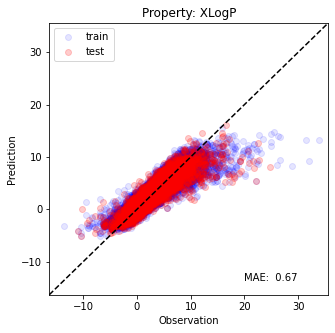

In [12]:
import numpy as np

y_all = training_XLogP
y_train_true = y_train_XLogP
y_train_pred = y_train_XLogP_pred
y_test_true = y_test_XLogP
y_test_pred = y_test_XLogP_pred

y_min = min(y_all)*0.95
y_max = max(y_all)*1.05
y_diff = y_max - y_min

plt.figure(figsize=(5,5))
plt.scatter(y_train_true, y_train_pred, c='b', alpha=0.1, label='train')
plt.scatter(y_test_true, y_test_pred, c='r', alpha=0.2, label='test')
plt.text(y_min+y_diff*0.7,y_min+y_diff*0.05,'MAE: {:5.2f}'.format(np.mean(np.abs(y_test_true - y_test_pred)),fontsize=12))
plt.xlim(y_min,y_max)
plt.ylim(y_min,y_max)
plt.legend(loc='upper left')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Property: XLogP')
plt.plot([y_min,y_max],[y_min,y_max],ls="--",c='k')

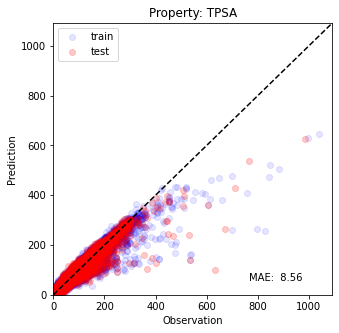

In [13]:
y_all = training_TPSA
y_train_true = y_train_TPSA
y_train_pred = y_train_TPSA_pred
y_test_true = y_test_TPSA
y_test_pred = y_test_TPSA_pred

y_min = min(y_all)*0.95
y_max = max(y_all)*1.05
y_diff = y_max - y_min

plt.figure(figsize=(5,5))
plt.scatter(y_train_true, y_train_pred, c='b', alpha=0.1, label='train')
plt.scatter(y_test_true, y_test_pred, c='r', alpha=0.2, label='test')
plt.text(y_min+y_diff*0.7,y_min+y_diff*0.05,'MAE: {:5.2f}'.format(np.mean(np.abs(y_test_true - y_test_pred)),fontsize=12))
plt.xlim(y_min,y_max)
plt.ylim(y_min,y_max)
plt.legend(loc='upper left')
plt.xlabel('Observation')
plt.ylabel('Prediction')
plt.title('Property: TPSA')
plt.plot([y_min,y_max],[y_min,y_max],ls="--",c='k')

In [14]:
from xenonpy.inverse.iqspr import GaussianLogLikelihood

## set property target
prop = ['XLogP', 'TPSA']
target_range = {'XLogP': (5, 10), 'TPSA': (50, 100)}
likelihood_calculator = GaussianLogLikelihood(descriptor=RD, targets=target_range, XLogP=model_XLogP, TPSA=model_TPSA)
samples_likelihood = likelihood_calculator(init_samples)
samples_likelihood.head()

,XLogP,TPSA
0,-3.997644,-5.032941
1,-6.912281,-3.094987
2,-8.090693,-2.093019
3,-4.755967,-4.908935
4,-3.293299,-1.176282


### 3. modifier
#### proposal
proposal substitute a randomly selected reactant by a similar one.

In [15]:
%%time
from xenonpy.contrib.ismd import ReactantPool
from xenonpy.contrib.ismd import load_reactor

model_path = os.path.join(assets_path,'STEREO_separated_augm_model_average_20.pt')
mol_reactor = load_reactor(model_path=model_path, device_id=1)
mol_pool = ReactantPool(pool_df=reactant_pool, sim_df=sim_df, reactor=mol_reactor)

CPU times: user 12 s, sys: 1.44 s, total: 13.5 s
Wall time: 3.32 s


In [16]:
init_samples["reactant_idx_old"] = init_samples["reactant_idx"]
old_list = [list(r) for r in init_samples["reactant_idx"]]
init_samples["reactant_idx"] = [mol_pool.single_propopsal(reactant) for reactant in old_list]
init_samples.head()

,reactant_idx,reactant_idx_old,reactant_smiles,product_smiles
0,[246895],[78978],NaN,C[C@H](O)c1ccccc1Br
1,"[427466, 269651]","[451314, 269651]",NaN,CCn1c(CNC)cc2ccccc21
2,"[348549, 23440]","[189231, 23440]",NaN,N#CCc1cccnc1Cl
3,"[421760, 11159]","[41132, 11159]",NaN,C=C1CCCc2c(O)cccc21
4,"[281918, 592471, 505281]","[281918, 10320, 505281]",NaN,CCCc1c(O)nc(C(F)(F)F)nc1CC


#### lookup pool
By looking up the reactant pool, convert reactant id to SMILES.

In [17]:
init_samples["reactant_smiles"] = [mol_pool.single_index2reactant(id_str) for id_str in init_samples["reactant_idx"]]
init_samples.head()

,reactant_idx,reactant_idx_old,reactant_smiles,product_smiles
0,[246895],[78978],C[C@H](N)c1ccccc1Br,C[C@H](O)c1ccccc1Br
1,"[427466, 269651]","[451314, 269651]",CN(Cc1cccc([N+](=O)[O-])c1)C(=O)OCc1ccccc1.O=C...,CCn1c(CNC)cc2ccccc21
2,"[348549, 23440]","[189231, 23440]",[O-][n+]1cccc(CO)c1.O=P(Cl)(Cl)Cl,N#CCc1cccnc1Cl
3,"[421760, 11159]","[41132, 11159]",CCC(C)(C)[O-].O=C1CCCc2c(O)cccc21,C=C1CCCc2c(O)cccc21
4,"[281918, 592471, 505281]","[281918, 10320, 505281]",CCCC(C(C)=O)C(=O)OCC.CC1(C)Nc2c(cc(-c3cccc4ncc...,CCCc1c(O)nc(C(F)(F)F)nc1CC


#### reactor
The reactor can predict the product given the reactant set.

In [18]:
init_samples["product_smiles"] = mol_pool._reactor.react(init_samples["reactant_smiles"])
init_samples.head()

,reactant_idx,reactant_idx_old,reactant_smiles,product_smiles
0,[246895],[78978],C[C@H](N)c1ccccc1Br,C[C@H](N)c1ccccc1Br
1,"[427466, 269651]","[451314, 269651]",CN(Cc1cccc([N+](=O)[O-])c1)C(=O)OCc1ccccc1.O=C...,CN(Cc1cccc([N+](=O)[O-])c1)C(=O)OC(=O)OCc1ccccc1
2,"[348549, 23440]","[189231, 23440]",[O-][n+]1cccc(CO)c1.O=P(Cl)(Cl)Cl,[O-][n+]1cccc(CO)c1Cl
3,"[421760, 11159]","[41132, 11159]",CCC(C)(C)[O-].O=C1CCCc2c(O)cccc21,COc1cccc2c1CCCC2=O
4,"[281918, 592471, 505281]","[281918, 10320, 505281]",CCCC(C(C)=O)C(=O)OCC.CC1(C)Nc2c(cc(-c3cccc4ncc...,CCCc1c(C)nc(C(F)(F)F)nc1O


### 4. a complete ismd run
In this tutorial, we use IQSPR4DF as the SMC framework, which is usable for pandas dataframe. The main building blocks of SMC is estimator and modifier which is build in the previous steps.

In [19]:
import numpy as np

beta = np.hstack([np.linspace(0.01,0.2,20),np.linspace(0.21,0.4,10),np.linspace(0.4,1,10),np.linspace(1,1,10)])
beta

array([0.01      , 0.02      , 0.03      , 0.04      , 0.05      ,
       0.06      , 0.07      , 0.08      , 0.09      , 0.1       ,
       0.11      , 0.12      , 0.13      , 0.14      , 0.15      ,
       0.16      , 0.17      , 0.18      , 0.19      , 0.2       ,
       0.21      , 0.23111111, 0.25222222, 0.27333333, 0.29444444,
       0.31555556, 0.33666667, 0.35777778, 0.37888889, 0.4       ,
       0.4       , 0.46666667, 0.53333333, 0.6       , 0.66666667,
       0.73333333, 0.8       , 0.86666667, 0.93333333, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [20]:
from xenonpy.contrib.ismd import IQSPR4DF

iqspr_reorder = IQSPR4DF(estimator=likelihood_calculator, modifier=mol_pool)

In [21]:
%%time

np.random.seed(201906) # fix the random seed
# main loop of iQSPR
iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for s, ll, p, freq in iqspr_reorder(init_samples, beta, sample_col='product_smiles', yield_lpf=True):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
# record all outputs
iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}


CPU times: user 8min 6s, sys: 14.4 s, total: 8min 20s
Wall time: 4min 48s


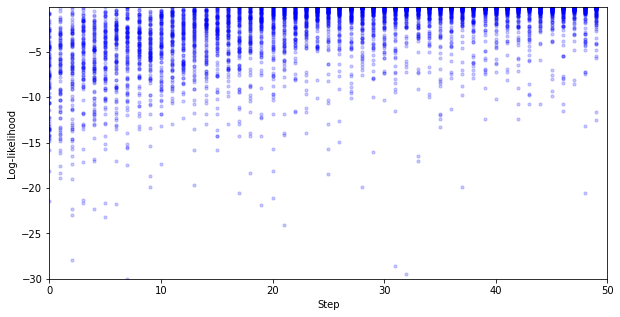

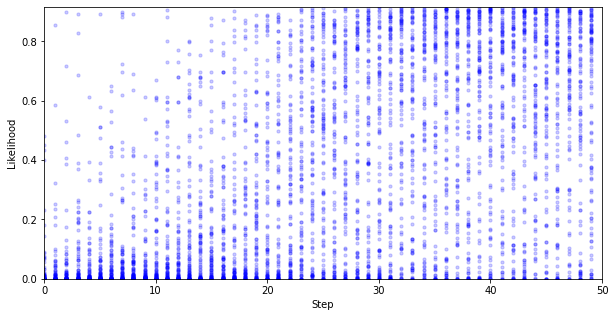

In [22]:
import matplotlib.pyplot as plt

iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}
# set up the min and max boundary for the plots
tmp_list = [x.sum(axis = 1, skipna = True).values for x in iqspr_results_reorder["loglike"]]
flat_list = np.asarray([item for sublist in tmp_list for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(-30,y_max)
plt.xlabel('Step')
plt.ylabel('Log-likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
plt.figure(figsize=(10,5))
plt.xlim(0,len(iqspr_results_reorder["loglike"]))
plt.ylim(y_min,y_max)
plt.xlabel('Step')
plt.ylabel('Likelihood')
for i, ll in enumerate(tmp_list):
    plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)